In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import data_explorer_aux_methods as de_am

In [2]:
# Retrieve data from the csv file
data_file_dir = "/home/jovyan/work/files/data/stocks_day.csv"
with open(data_file_dir, 'r') as file:
    df_etfs =  pd.read_csv(file)
df_etfs

,date,stock_symbol,open,high,low,close,volume
0,2017-11-06,FLAU,25.160,25.160,25.160,25.160,101
1,2017-11-07,FLAU,25.160,25.160,25.070,25.160,12100
2,2017-11-08,FLAU,25.160,25.160,25.160,25.160,0
3,2017-11-09,FLAU,25.520,25.520,25.520,25.520,200
4,2017-11-10,FLAU,25.530,25.530,25.530,25.530,100
...,...,...,...,...,...,...,...
36980,2023-11-03,FLZA,19.530,19.530,19.500,19.530,270
36981,2023-11-06,FLZA,19.480,19.480,19.460,19.470,2006
36982,2023-11-07,FLZA,19.500,19.575,19.500,19.575,780
36983,2023-11-08,FLZA,19.575,19.575,19.575,19.575,25


In [3]:
## Let's explore the data! ##

In [4]:
# 0 - A quick missing data check!
df_etfs.isna().sum()

date            0
stock_symbol    0
open            0
high            0
low             0
close           0
volume          0
dtype: int64

In [5]:
# Example of analysing a single ETF:#
stock_symbol = 'FLSW'
df = df_etfs[df_etfs['stock_symbol'] == stock_symbol].copy(deep=True)

# 1- Let's find out how their (average) opening value increased
# per month/year)!

# 1.1 - First challenge, we notice the date isn't actually a
# "datetime" type, but a string!  
print(type(df['date'].iat[0])) # Checking the first row of the 'date' column
# Let's make it a datetime.
df['date'] = pd.to_datetime(df['date'])
print(type(df['date'].iat[0])) # We have a date! (Not romantically)

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [6]:
# 1.2 - Now we do a bit of feature transformation to conveniently spread the date into
#       3 columns (year, month, day)
df['year'], df['month'], df['day'] = df['date'].dt.year, df['date'].dt.month, df['date'].dt.day
# 1.3 - We also get a year/month only column since it would be useful to do a time-series analysis
#       in that date format (we don't really need to plot each day, do we? :D)
df['year_month'] = df['date'].dt.strftime("%Y-%m")
#df['year_month'] = pd.to_datetime(df['date'].dt.strftime("%Y-%m"))


df.drop(columns='date', inplace=True)
cols = df.columns.to_list()
cols = cols[-3:] + cols[:-3]
df = df[cols]

In [7]:
#1.4 - Get our means
df_mean_ym = df.groupby(by=[df['year_month'], df['year'], df['month']], as_index=False)['open'].mean()

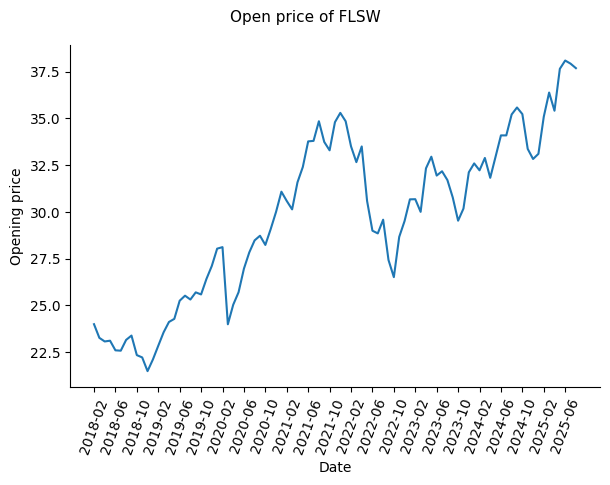

In [8]:
#1.5 - Plot 
n_xticks = 20

plot_op = sns.relplot(x=df_mean_ym['year_month'], y=df_mean_ym['open'],
                     kind='line', legend='auto') # plot open price
plot_op.fig.suptitle(t=f"Open price of {stock_symbol}", fontsize=11)
plot_op.set_axis_labels('Date', 'Opening price')
plot_op.set(xticks=range(0, df_mean_ym.shape[0]-1, int(np.floor(df_mean_ym.shape[0]/n_xticks))))
plot_op.set_xticklabels(rotation=70)
plot_op.fig.set_size_inches(6.2, 4.9)
plt.tight_layout()
plt.show()

In [9]:
df_mean_ym

,year_month,year,month,open
0,2018-02,2018,2,23.990000
1,2018-03,2018,3,23.259476
2,2018-04,2018,4,23.066190
3,2018-05,2018,5,23.106818
4,2018-06,2018,6,22.592000
...,...,...,...,...
86,2025-04,2025,4,35.408081
87,2025-05,2025,5,37.649252
88,2025-06,2025,6,38.093825
89,2025-07,2025,7,37.926709


In [10]:
# 1 - (Analysis + storytelling): In the FLSW case, it seems to be on an verall rising trend, although with fluctuations.
# The steepest one appears to coincide with a period where the invasion of Ukraine sarted. There also seems to be a decrease
# around or slightly after every month of October.

In [11]:
# Fills numeric columns of one ETF with the values of another in the same
#  date (index), so that the average stays the same when these stocks are
#  combined into a "regional" one. 
# Categorical values are simply "propagated" (with the mode)
def suffix_fillna(df, suffix_nans, suffix):
    for column_name in df.columns:
        if column_name.endswith(suffix_nans):
            if np.issubdtype(df[column_name].dtype, np.number):
                # Fill value with that of the other ETF.
                column_name_nans = column_name
                column_name = column_name.removesuffix(suffix_nans) + suffix #get the name of the other colum
                df.fillna({column_name_nans : df[column_name]}, inplace=True)
                
            elif np.issubdtype(df[column_name].dtype, object):
                # Fill with the same value as others from that column
                df.fillna({column_name : df[column_name].mode()}, inplace=True)
            
    return df

In [12]:
pd.options.display.max_rows = 50
pd.options.display.min_rows = 50

def combine_into_FNAX(df_etfs):
    etfs = ['FLMX', 'FLCA']
    etf_suffixes = ['_' + etfs[0], '_' + etfs[1]]
    column_names = df_etfs.columns
    column_shared_names = ['year_month', 'year', 'month', 'day']
    df_fnax = pd.DataFrame()
    
    df_temp = df_etfs[df_etfs['stock_symbol'] == 'FLMX'] 
    df_temp = df_temp.merge(df_etfs[df_etfs['stock_symbol'] == 'FLCA'], on=column_shared_names,
                            how='left', suffixes=etf_suffixes)

    # Check if they have uncorresponded dates
    if df_temp['stock_symbol_FLMX'].isna().sum() != 0:
        df_temp = suffix_fillna(df_temp, etf_suffixes[0], etf_suffixes[1]) # copy value from the other column
    if df_temp['stock_symbol_FLCA'].isna().sum() != 0:
        df_temp = suffix_fillna(df_temp, etf_suffixes[1], etf_suffixes[0]) 
    
    for column_name in column_names:
        # When merging the ETFs, preserve the shared columns
        if column_name in column_shared_names:
            df_fnax[column_name] = df_temp[column_name]
        # If it's not shared and its numerical, average it
        elif np.issubdtype(df_etfs[column_name], np.number):
            df_fnax[column_name] = (
                    df_temp[column_name + etf_suffixes[0]] 
                    + df_temp[column_name + etf_suffixes[1]]
            ) / 2
        # The <stock_symbol> column will now have the merge name 'FNAX'
        elif column_name == 'stock_symbol':
            df_fnax['stock_symbol'] = 'FNAX'
    
    # Append FNAX to the ETF
    df_etfs = pd.concat([df_etfs, df_fnax], axis=0)
   
    return df_etfs

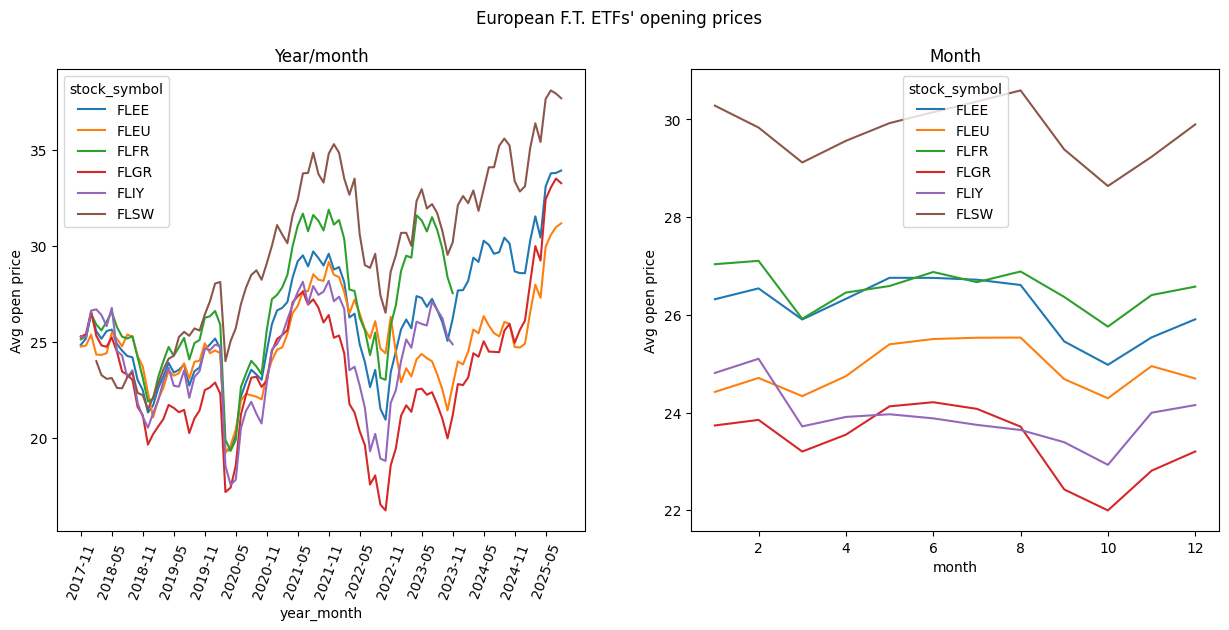

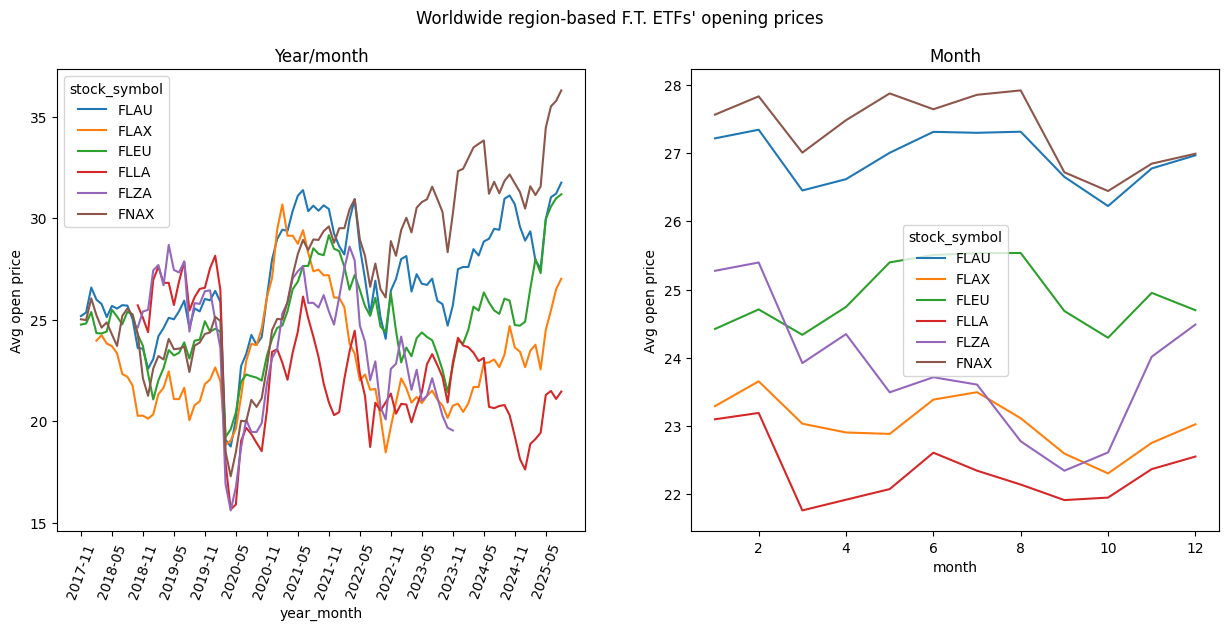

In [17]:
# 1.6 - Plotting multiple ETFs at once for a more general analysis
# 1.6.1 - European analysis (european country's ETFs as well as Europe and Eurozone ETFs)
# 1.6.2 - A more global analysis (region-wide ETFs)
stock_symbol_groups = {'European' : ['FLFR', 'FLGR', 'FLIY', 'FLSW', 'FLEU', 'FLEE'],
                       'Worldwide region-based' : ['FNAX', 'FLLA', 'FLEU', 'FLZA', 'FLAX', 'FLAU']
                      }
#eu_stock_symbols = ['FLFR', 'FLGR', 'FLIY', 'FLSW', 'FLEU', 'FLEE']
#world_stock_symbols = ['FNAX', 'FLLA', 'FLEU', 'FLZA', 'FLAX', 'FLAU']

# Let's re-transform our data, but this time for good.
if 'date' in df_etfs.columns:
    df_etfs['date'] = pd.to_datetime(df_etfs['date'])
    df_etfs['year'], df_etfs['month'], df_etfs['day'] = df_etfs['date'].dt.year, df_etfs['date'].dt.month, df_etfs['date'].dt.day
    df_etfs['year_month'] = pd.to_datetime(df_etfs['date'].dt.strftime('%Y-%m'))

    df_etfs.drop(columns='date', inplace=True)
    cols = df_etfs.columns.to_list()
    cols = cols[-3:] + cols[:-3]
    df_etfs = df_etfs[cols]

# Now we get our 'open' means (om) per year/month
# It seems checking per year/month is less readable than
# what could be desirable. Let's try by year:
suptitles = ['European F.T. ETFs\' opening prices', 'Worldwide region-based F.T. ETFs\' opening prices']

for key in stock_symbol_groups.keys():
    if key == 'Worldwide region-based':
        df_etfs = combine_into_FNAX(df_etfs)
    de_am.time_frame_plot_etfs(df_etfs, stock_symbol_groups[key], key)

# Done:
# year_month has successfully been converted to a Timestamp (except on the 1.1 cell).
    
#To do
# Check why in the 1.1 cell converting year_month to a Timestamp gives error in the plot
# Do the "Worldwide" part (including the 'NAX' part, possibly with a left join) 
#
# A grouped bar plot might be a better choice!
# Plot year/monthly and monthly percent rises and falls
# Plot highest percent decreasewithin a time frame where all ETFs are registered

In [14]:
#2 - Let's analyse the monthly increases of many
# For comparison, to make it fairer, I think it's best if we analyse the
# ETFs in the same time period.
# So first, let's check their oldest and latest analysed dates:

# To find a common period for all, we'll take the "smallest" (oldest)
# most recent date, and the largest (most recent) oldest date (sounds confusing when
# typed doesn't it? Think of it as the maximum of the minimums and the minimum of the maximums)

In [15]:
## Dataset analysis ##
# Missing data

## Univariate analysis ##
# Number of occurrences and frequency
# Mean, max, min, median, variance
# Time-series with one other variable
# Numerical target variable with a categorical grouping it
# Numerical target in function of a numerical predictor
# (regression (scatter plot with a r. line) 

# Multivariate analysis
# Time-series with 2+ variables
# Correlation with heat map or line plot
# counting multiple occurrences
# violin plot to show multiple distributions based on a certain variable
# (such as time)

# Plots
#
# Correlations - Scatter plot, heat map;
# Trend - Line plot (continous variable), Bar plot (discrete var.)
# Median, 25th, 75th percentiles, outlier threshold - Box plot
# Distribution of multiple variables at once - Violin plot
# Percentage that sums up to a whole - Pie chart